In [34]:
!pip install open_clip_torch torch torchvision pillow numpy tqdm --quiet


In [35]:
import os, glob, json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch, open_clip
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive

In [36]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
INPUT_DIR = "/content/drive/MyDrive/40_Random"
OUTPUT_FILE = "/content/zeroshot_100sample_results.jsonl"



In [38]:
ZERO_SHOT_PROMPTS = {
    "PROTEST_STREET": [
        "people marching on city streets holding protest signs",
        "large outdoor protest with banners and flags",
        "crowd of activists chanting and raising placards",
        "demonstration or rally with people carrying posters",
        "street march with protesters and slogans",
        "group of people protesting in public square",
        "protesters with megaphones and raised fists outdoors"
    ],

    "INSTITUTIONAL_STAGE": [
        "politician speaking at a podium in a press room",
        "official press conference with microphones and reporters",
        "government meeting or briefing with formal background",
        "person giving speech indoors behind podium",
        "conference or summit with officials seated at table",
        "formal government event with national flags behind speaker",
        "indoor political address with microphones and cameras"
    ],

    "CAMPUS_EVENT": [
        "students sitting in a classroom or lecture hall",
        "college campus scene with young people studying outdoors",
        "professor teaching in front of a class",
        "university lecture with audience of students",
        "students gathered in campus quad or classroom discussion",
        "college classroom with whiteboard and projector",
        "academic presentation or student workshop"
    ],

    "MEDIA_PROPAGANDA": [
        "digital meme with text overlay and photo",
        "social media screenshot with interface elements",
        "edited poster or propaganda graphic",
        "TV news broadcast with on-screen text",
        "infographic with bold captions and pictures",
        "social media post with image and caption",
        "composite digital image made for online sharing"
    ],

    "UNKNOWN": [
        "random everyday scene with no clear topic",
        "unrelated image without crowds or podiums",
        "generic object or landscape photo"
    ]
}


In [39]:
def list_images(folder):
    exts = (".jpg",".jpeg",".png",".webp",".bmp")
    paths = []
    for e in exts:
        paths += glob.glob(os.path.join(folder, f"*{e}"))
    return sorted(paths)

all_images = list_images(INPUT_DIR)
print(f"🔹 Found {len(all_images)} images in {INPUT_DIR}")


🔹 Found 40 images in /content/drive/MyDrive/40_Random


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-L-14"
pretrained_ckpt = "laion2b_s32b_b82k"

model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_ckpt)
tokenizer = open_clip.get_tokenizer(model_name)
model.eval().to(device)
print(f"✅ Loaded {model_name} ({pretrained_ckpt}) on {device}")


✅ Loaded ViT-L-14 (laion2b_s32b_b82k) on cpu


In [41]:
label_vectors = {}
with torch.no_grad():
    for label, prompts in ZERO_SHOT_PROMPTS.items():
        tok = tokenizer(prompts).to(device)
        vecs = model.encode_text(tok)
        vecs = vecs / vecs.norm(dim=-1, keepdim=True)
        label_vectors[label] = vecs.mean(dim=0, keepdim=True)

labels = list(label_vectors.keys())
tvec = torch.cat([label_vectors[lbl] for lbl in labels], dim=0)

In [42]:
results = []
temperature = 0.03   # sharper confidence spread
for path in tqdm(all_images):
    try:
        img = Image.open(path).convert("RGB")
    except Exception:
        continue

    with torch.no_grad():
        x = preprocess(img).unsqueeze(0).to(device)
        ivec = model.encode_image(x)
        ivec = ivec / ivec.norm(dim=-1, keepdim=True)
        sims = (ivec @ tvec.T).squeeze(0).cpu().numpy()

    scene_sims = sims[:-1]        # exclude UNKNOWN
    unk_sim = float(sims[-1])

    # Softmax normalization across classes
    exp_sims = np.exp(scene_sims / temperature)
    probs = exp_sims / np.sum(exp_sims)
    max_prob = np.max(probs)
    best_idx = int(np.argmax(probs))
    best_label = labels[best_idx]

    # Confidence-based decision (tighter threshold)
    is_unknown = max_prob < 0.70 or (max_prob < 0.75 and unk_sim > np.mean(scene_sims))
    label = "unknown" if is_unknown else best_label

    results.append({
        "path": os.path.basename(path),
        "label": label,
        "confidence": round(float(max_prob),3),
        "best_sim": round(float(scene_sims[best_idx]),4),
        "unk_sim": round(unk_sim,4)
    })


100%|██████████| 40/40 [02:40<00:00,  4.02s/it]


In [46]:
# 8️⃣ Save results
with open(OUTPUT_FILE, "w") as f:
    for r in results:
        f.write(json.dumps(r) + "\n")

print(f"\n✅ Done! Classified {len(results)} images.")
print(f"Results saved to: {OUTPUT_FILE}")

# 9️⃣ Summary
counts = Counter(r["label"] for r in results)
print("\n📊 Label counts:")
for lbl, c in counts.items():
    print(f"{lbl:20s} → {c:4d}")


✅ Done! Classified 40 images.
Results saved to: /content/zeroshot_100sample_results.jsonl

📊 Label counts:
unknown              →   17
PROTEST_STREET       →   11
MEDIA_PROPAGANDA     →   12


,path,label,confidence,best_sim,unk_sim
0,2848410766023731083__284529430_340934021319534...,unknown,0.743,0.2306,0.1630
1,2848410766023731083__284645805_787670909264484...,PROTEST_STREET,0.952,0.2058,0.1418
2,2849126906832291056__284356575_713238196573997...,unknown,0.509,0.1742,0.1182
3,2849656145477240143__284645804_755471129155733...,unknown,0.268,0.1654,0.1267
4,2983720566764124471__501685915_125699362249979...,PROTEST_STREET,0.946,0.2193,0.1347
5,451343914_496616053018135_2586767934785121431_...,MEDIA_PROPAGANDA,0.948,0.1851,0.1421
6,452842052_1017585399767829_1218373299653330229...,unknown,0.659,0.1356,0.1682
7,452856948_815909363643449_8261195655921378787_...,MEDIA_PROPAGANDA,0.803,0.1053,0.1618
8,452857080_7906272059485882_13013324345258530_n...,unknown,0.664,0.1479,0.1303
9,452859706_502781995554325_267712069011515191_n...,PROTEST_STREET,0.912,0.1998,0.1613


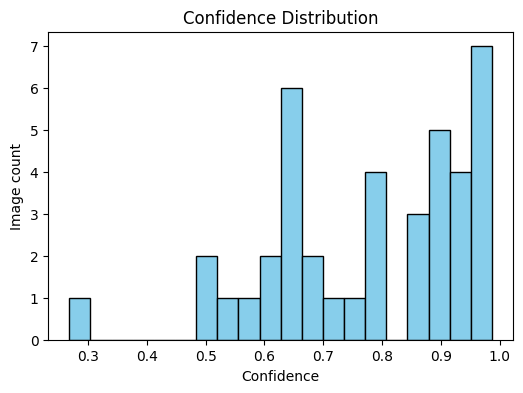

In [44]:
df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 160)
display(df)

# 11️⃣ Confidence histogram
plt.figure(figsize=(6,4))
plt.hist(df["confidence"], bins=20, color="skyblue", edgecolor="k")
plt.title("Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Image count")
plt.show()

In [45]:
import pandas as pd, json

# Convert jsonl → DataFrame
df = pd.read_json("40_results_vlm.jsonl", lines=True)
df = pd.concat([df.drop(['result'], axis=1), df['result'].apply(pd.Series)], axis=1)

# Show first few rows
print(df[['image','scene_type','confidence_0_1','caption_20w']].head())


                                               image    scene_type  confidence_0_1                                caption_20w
0  sample_images/40_png_images/453583954_15500321...       unknown             0.0                                           
1  sample_images/40_png_images/453963858_13801133...       unknown             0.0                young boy with text overlay
2  sample_images/40_png_images/453711520_95280419...       unknown             0.0  a pile of trash and garbage on the ground
3  sample_images/40_png_images/453575633_11833877...       unknown             0.0                      newborn baby sleeping
4  sample_images/40_png_images/452856948_81590936...  CAMPUS_EVENT             0.0   diver on platform at Paris 2024 Olympics
